In [1]:
!pip install aotools

In [2]:
import aotools
import numpy as np
from aotools import opticalpropagation
from aotools.turbulence import infinitephasescreen, phasescreen
import matplotlib.pylab as plt
from tqdm import tqdm, trange, tqdm_notebook
import math

w0=  0.05 , wRx_no_turb= 0.07500000000000001 , wRx_with_turb=  0.16151910719089135


100%|██████████| 2/2 [00:00<00:00, 166.67it/s]
C:\Users\Lerishia\AppData\Local\Temp/ipykernel_27764/3168919155.py:79: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  cp = ax2.pcolormesh(X, Y, I, cmap="rainbow")


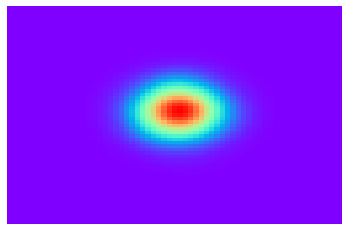

In [5]:
for n in range(1):
    
    D = 0.3 #1. total size of the grid [m] 
    stencil_length_factor = 32
    nx_size = 64  #number of grid points per side
    pxl_scale = D/nx_size # % grid spacing [m] wvl*z/W

    x = np.arange(-D/2,D/2, pxl_scale) 
    y = np.arange(-D/2,D/2, pxl_scale) 
    xx, yy = np.meshgrid(x, y, sparse=True)

    wavelength = 532.0e-9 # (m) 
    k = 2*np.pi/wavelength #Wave number

    cn2 = 1e-14 #1e-13 set the strenght of the atmospheric turbulence
    r0 = aotools.turbulence.atmos_conversions.cn2_to_r0(cn2=cn2, lamda=wavelength)

    l0=0.001 # inner scale (m)
    L0 = 100 / (nx_size/2) # outer scale (m)
    j = 0+1j

    L = 5e3 #Distance (m) propagation distance

    w0 = 5.0e-2 # inital beam radius (m) 2.5e-2 
    teta0 = 10e-6 #beam divergence (rad)
    wL = w0/2 + L*teta0 #final beam width at receiver (without turbulence) (m)
    zR = np.pi*w0**2/wavelength #Rayleigh range

    P = 0.1 #Total power (W)


    IL = 2*P / (np.pi*wL)**2 #I(r,z) = 2*P / (pi*w(z)^2) * exp(-2*r^2 / w(z)^2)


    def qz(z): #complex beam parameter
        return z + j*zR
    gaussian_wavefront = 1/qz(L) * np.exp( -j*k*(xx**2+yy**2)/(2*qz(L)) ) # *np.exp(j*k*L)


    #Theoretic calculation for comparison
    sR2 = 1.23*cn2*k**(7/6)*L**(11/6) #Rytov variance
    wRxL = wL *np.sqrt(1 + 1.33*sR2 *(2*L/ (k*wL**2))**(5/6)) #Atmospheric turbulence added

    print("w0= ", w0, ", wRx_no_turb=",wL, ", wRx_with_turb= ", wRxL)





    # Generate a large set of phase screens
    N_scrns = 2

    #wavefronts = np.zeros((N_scrns, nx_size, nx_size))
    Is = np.zeros((N_scrns, nx_size, nx_size))
    powerspec = np.zeros_like(Is)

    for i in tqdm(range(N_scrns)):
        phase_screen = phasescreen.ft_phase_screen(r0, nx_size, pxl_scale, L0, l0, FFT=None, seed=None) #von Karman
        #phase_screen = infinitephasescreen.PhaseScreenVonKarman(nx_size, pxl_scale, r0, L0).scrn
        #phase_screen = infinitephasescreen.PhaseScreenKolmogorov(nx_size, pxl_scale, r0, L0, stencil_length_factor=stencil_length_factor).scrn    


        wavefront = gaussian_wavefront * np.exp(j*phase_screen)

        m=1
        propagated_wavefront = aotools.opticalpropagation.angularSpectrum(wavefront, wavelength, m*pxl_scale, m*pxl_scale, L)

        Is[i] = IL*np.abs(propagated_wavefront)**2


    I=Is.mean(0)   

    #ax = plt.axes(projection='3d') 
    #ax.plot_surface(xx, yy, I, cmap="rainbow");

    import matplotlib.colors as colors
    X, Y = np.meshgrid(x, y)
    fig,ax2=plt.subplots(1,1)
    cp = ax2.pcolormesh(X, Y, I, cmap="rainbow")
    plt.axis('off')
    #cp = ax2.contourf(X, Y, I, cmap="rainbow")
    #fig.colorbar(cp)
    plt.show
    plt.savefig("testing image"+str(cn2)+"gaussian_turbulence{0}".format(n), dpi=500)
    
    

    
    
    